In [2]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
def load_animal_dataset(dataset_path):
    images = []
    labels = []
    class_images = {}

    for label_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, label_name)

        if not os.path.isdir(class_folder):
            continue

        class_images[label_name] = []

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)

            try:
                img = Image.open(img_path)
                img_array = np.array(img)

                images.append(img_array)
                labels.append(label_name)
                class_images[label_name].append(img_array)

            except Exception as e:
                print("Failed to load:", img_path, "Error:", e)

    print("Total images loaded:", len(images))
    return images, labels, class_images


def show_samples(class_images, samples_per_class=3):
    for class_name, img_list in class_images.items():
        print(f"\nShowing samples for: {class_name}")

        sample_imgs = random.sample(img_list, min(samples_per_class, len(img_list)))

        plt.figure(figsize=(10, 3))
        for i, img in enumerate(sample_imgs):
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

        plt.show()


Total images loaded: 300

Showing samples for: cat


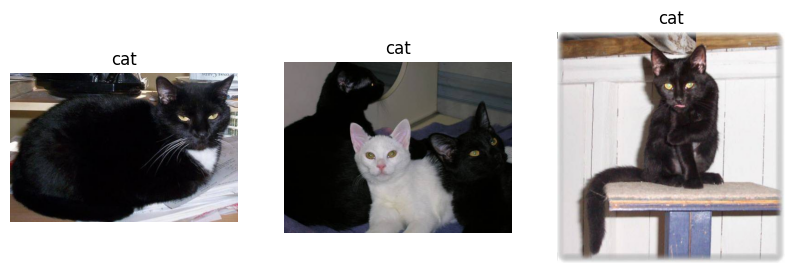


Showing samples for: dog


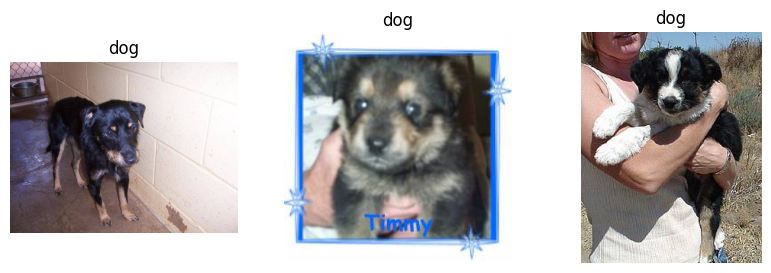


Showing samples for: panda


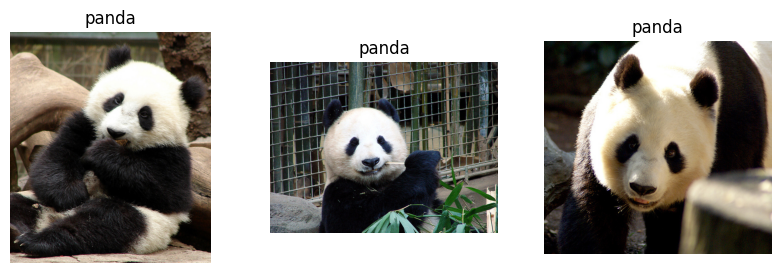

In [4]:
images, labels, class_images = load_animal_dataset("animal_dataset")
show_samples(class_images=class_images)

In [5]:
def preprocess_images(images, labels, class_map=None, normalize=True, enhance=True):
    """
    Preprocess raw images for ML models.

    Parameters:
        images : list of np.array
            Raw images (RGB or grayscale)
        labels : list of str
            Class names
        class_map : dict, optional
            Mapping from class name to integer
        normalize : bool
            If True, scale pixels to [0,1]
        enhance : bool
            If True, apply histogram equalization for better contrast

    Returns:
        X : np.ndarray
            Preprocessed flattened images (N, 1024)
        y : np.ndarray
            Integer labels (N,)
        class_map : dict
            Mapping class name -> integer label
    """
    if class_map is None:
        classes = sorted(list(set(labels)))
        class_map = {cls: idx for idx, cls in enumerate(classes)}

    X_list = []
    y_list = []

    for img, lbl in zip(images, labels):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_resized = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
        
        if enhance:
            img_resized = cv2.equalizeHist(img_resized)
        
        img_resized = cv2.GaussianBlur(img_resized, (3, 3), 0)

        X_list.append(img_resized.flatten())

        y_list.append(class_map[lbl])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    if normalize:
        X /= 255.0
        
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0) + 1e-8
        X = (X - mean) / std

    return X, y, class_map


In [6]:
X, y, class_map = preprocess_images(images, labels)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class map:", class_map)


X shape: (300, 1024)
y shape: (300,)
Class map: {'cat': 0, 'dog': 1, 'panda': 2}


In [7]:
def show_samples_of_class(X, y, class_label, samples=3, img_shape=(32,32)):
    """
    Display sample images of a single class.

    Parameters:
        X : np.ndarray
            Preprocessed images (N, 1024) or (N, H, W)
        y : np.ndarray
            Labels (N,)
        class_label : int or str
            Label of the class to show
        samples : int
            Number of images to display
        img_shape : tuple
            Shape to reshape flattened images
    """
    indices = np.where(y == class_label)[0]
    sample_indices = random.sample(list(indices), min(samples, len(indices)))

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(sample_indices):
        img = X[idx].reshape(img_shape) if len(X.shape) == 2 else X[idx]
        plt.subplot(1, samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {class_label}")
        plt.axis('off')
    plt.show()


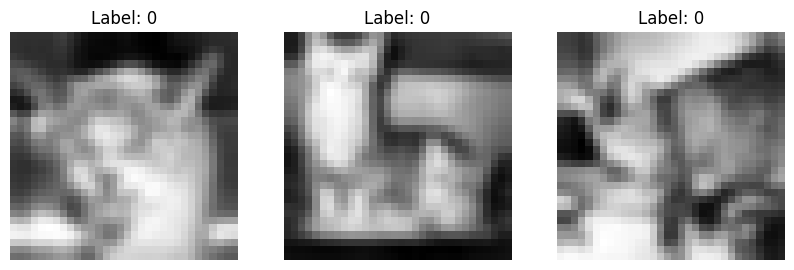

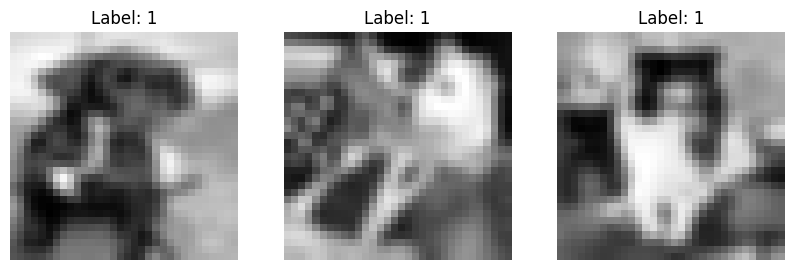

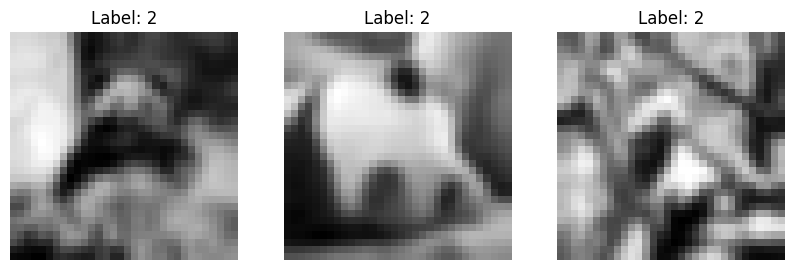

In [8]:
show_samples_of_class(X, y, class_label=0)
show_samples_of_class(X, y, class_label=1)
show_samples_of_class(X, y, class_label=2)

In [9]:
def l1_distance(a, b):
    """Manhattan distance between two vectors"""
    return np.sum(np.abs(a - b), axis=1)

def l2_distance(a, b):
    """Euclidean distance between two vectors"""
    return np.sqrt(np.sum((a - b)**2, axis=1))


In [10]:
def knn_predict(X_train, y_train, X_test, k=3, distance_metric='l2', weighted=True):
    """
    Predict labels for X_test using k-NN with distance weighting.

    Parameters:
        X_train : np.ndarray, shape (N_train, D)
        y_train : np.ndarray, shape (N_train,)
        X_test  : np.ndarray, shape (N_test, D)
        k : int, number of neighbors
        distance_metric : str, 'l1' or 'l2'
        weighted : bool, if True use distance-weighted voting

    Returns:
        y_pred : np.ndarray, shape (N_test,)
    """
    y_pred = []

    for test_vec in X_test:
        if distance_metric == 'l1':
            distances = l1_distance(X_train, test_vec)
        elif distance_metric == 'l2':
            distances = l2_distance(X_train, test_vec)
        else:
            raise ValueError("distance_metric must be 'l1' or 'l2'")

        nn_indices = np.argsort(distances)[:k]
        nn_distances = distances[nn_indices]
        nn_labels = y_train[nn_indices]

        if weighted:
            weights = 1.0 / (nn_distances + 1e-5)
            
            label_weights = {}
            for label, weight in zip(nn_labels, weights):
                label_weights[label] = label_weights.get(label, 0) + weight
            
            most_common = max(label_weights, key=label_weights.get)
        else:
            most_common = Counter(nn_labels).most_common(1)[0][0]
        
        y_pred.append(most_common)

    return np.array(y_pred)


In [11]:
def cross_validate_knn(X, y, k_values, distance_metric='l2', n_splits=5, weighted=True):
    """
    Perform k-fold cross-validation for k-NN.

    Parameters:
        X : np.ndarray, features
        y : np.ndarray, labels
        k_values : list of ints, different k to try
        distance_metric : 'l1' or 'l2'
        n_splits : int, number of folds
        weighted : bool, use distance-weighted voting

    Returns:
        avg_accuracies : dict, {k: avg_accuracy}
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    avg_accuracies = {}

    for k in k_values:
        fold_accuracies = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            y_pred = knn_predict(X_train, y_train, X_val, k=k, distance_metric=distance_metric, weighted=weighted)
            acc = accuracy_score(y_val, y_pred)
            fold_accuracies.append(acc)

        avg_accuracies[k] = np.mean(fold_accuracies)

    return avg_accuracies


Testing with WEIGHTED k-NN (distance-weighted voting):

L1 (Manhattan) weighted accuracies: {1: 0.39333333333333337, 3: 0.4366666666666667, 5: 0.4533333333333333, 7: 0.47000000000000003, 9: 0.4333333333333333, 11: 0.45, 13: 0.4666666666666666, 15: 0.47666666666666674}
L2 (Euclidean) weighted accuracies: {1: 0.39333333333333337, 3: 0.4333333333333333, 5: 0.45, 7: 0.45666666666666667, 9: 0.45, 11: 0.44000000000000006, 13: 0.4533333333333333, 15: 0.47000000000000003}

Testing with UNWEIGHTED k-NN (simple majority voting):

L1 (Manhattan) unweighted accuracies: {1: 0.39333333333333337, 3: 0.4366666666666667, 5: 0.44666666666666666, 7: 0.47333333333333344, 9: 0.44333333333333336, 11: 0.45, 13: 0.4633333333333334, 15: 0.46333333333333326}
L2 (Euclidean) unweighted accuracies: {1: 0.39333333333333337, 3: 0.4333333333333333, 5: 0.42666666666666664, 7: 0.4600000000000001, 9: 0.45, 11: 0.42666666666666664, 13: 0.44666666666666666, 15: 0.4666666666666667}


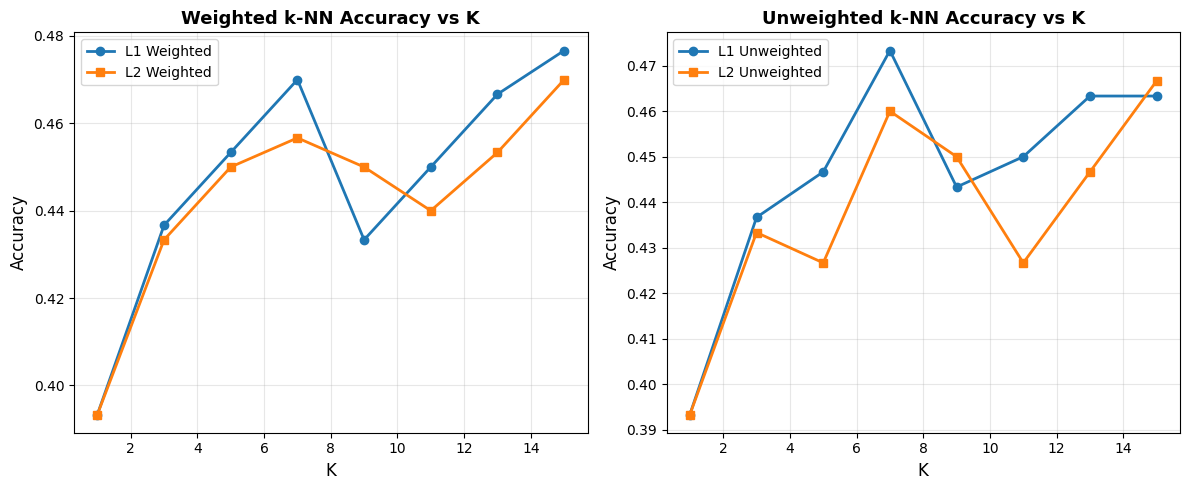


✓ Best K for L2 Weighted: 15 with accuracy 47.00%
  Recommended to use K=15 for final predictions


In [12]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

print("Testing with WEIGHTED k-NN (distance-weighted voting):\n")

l1_acc_weighted = cross_validate_knn(X, y, k_values, distance_metric='l1', weighted=True)
print("L1 (Manhattan) weighted accuracies:", l1_acc_weighted)

l2_acc_weighted = cross_validate_knn(X, y, k_values, distance_metric='l2', weighted=True)
print("L2 (Euclidean) weighted accuracies:", l2_acc_weighted)

print("\nTesting with UNWEIGHTED k-NN (simple majority voting):\n")

l1_acc = cross_validate_knn(X, y, k_values, distance_metric='l1', weighted=False)
print("L1 (Manhattan) unweighted accuracies:", l1_acc)

l2_acc = cross_validate_knn(X, y, k_values, distance_metric='l2', weighted=False)
print("L2 (Euclidean) unweighted accuracies:", l2_acc)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, [l1_acc_weighted[k] for k in k_values], marker='o', label='L1 Weighted', linewidth=2)
plt.plot(k_values, [l2_acc_weighted[k] for k in k_values], marker='s', label='L2 Weighted', linewidth=2)
plt.xlabel("K", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Weighted k-NN Accuracy vs K", fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, [l1_acc[k] for k in k_values], marker='o', label='L1 Unweighted', linewidth=2)
plt.plot(k_values, [l2_acc[k] for k in k_values], marker='s', label='L2 Unweighted', linewidth=2)
plt.xlabel("K", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Unweighted k-NN Accuracy vs K", fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k_l2_weighted = max(l2_acc_weighted, key=l2_acc_weighted.get)
print(f"\n✓ Best K for L2 Weighted: {best_k_l2_weighted} with accuracy {l2_acc_weighted[best_k_l2_weighted]*100:.2f}%")
print(f"  Recommended to use K={best_k_l2_weighted} for final predictions")


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
def show_top5_predictions_with_accuracy(X, y, k=5, distance_metric='l2', test_size=0.2, n_splits=5, weighted=True):
    """
    Evaluates k-NN performance with comprehensive metrics and displays predictions.
    No image visualization - only text-based output for clarity.
    """
    
    class_names = {0: 'Cat', 1: 'Dog', 2: 'Panda'}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
    print("="*80)
    print(f"{'k-NN CLASSIFIER EVALUATION REPORT':^80}")
    print("="*80)
    print(f"\n{'Configuration:':<30}")
    print(f"  • Algorithm:                 k-Nearest Neighbors (k={k})")
    print(f"  • Distance Metric:           {distance_metric.upper()} ({'Euclidean' if distance_metric=='l2' else 'Manhattan'})")
    print(f"  • Voting Method:             {'Distance-Weighted' if weighted else 'Simple Majority'}")
    print(f"  • Training Samples:          {len(X_train)} ({(1-test_size)*100:.0f}%)")
    print(f"  • Testing Samples:           {len(X_test)} ({test_size*100:.0f}%)")
    print(f"  • Cross-Validation Folds:    {n_splits}")
    print("\n" + "-"*80)
    
    print(f"\n{'TRAINING PHASE':<30}")
    train_pred = []
    for i in range(len(X_train)):
        test_vec = X_train[i]
        others_idx = np.array([j for j in range(len(X_train)) if j != i])
        train_dists = l2_distance(X_train[others_idx], test_vec) if distance_metric=='l2' else l1_distance(X_train[others_idx], test_vec)
        nn_idx = np.argsort(train_dists)[:k]
        nn_distances = train_dists[nn_idx]
        nn_labels = y_train[others_idx][nn_idx]
        
        if weighted:
            weights = 1.0 / (nn_distances + 1e-5)
            label_weights = {}
            for label, weight in zip(nn_labels, weights):
                label_weights[label] = label_weights.get(label, 0) + weight
            pred_label = max(label_weights, key=label_weights.get)
        else:
            pred_label = max(set(nn_labels), key=list(nn_labels).count)
        
        train_pred.append(pred_label)
    
    train_accuracy = accuracy_score(y_train, train_pred) * 100
    print(f"  Training Accuracy:           {train_accuracy:.2f}%")
    
    print(f"\n{'TESTING PHASE':<30}")
    test_pred = []
    test_details = []
    
    for idx, test_vec in enumerate(X_test):
        dists = l2_distance(X_train, test_vec) if distance_metric=='l2' else l1_distance(X_train, test_vec)
        nn_idx = np.argsort(dists)[:k]
        nn_distances = dists[nn_idx]
        nn_labels = y_train[nn_idx]
        
        if weighted:
            weights = 1.0 / (nn_distances + 1e-5)
            label_weights = {}
            for label, weight in zip(nn_labels, weights):
                label_weights[label] = label_weights.get(label, 0) + weight
            pred_label = max(label_weights, key=label_weights.get)
        else:
            pred_label = max(set(nn_labels), key=list(nn_labels).count)
        
        test_pred.append(pred_label)
        
        test_details.append({
            'idx': idx + 1,
            'actual': y_test[idx],
            'predicted': pred_label,
            'neighbors': nn_labels.tolist(),
            'distances': nn_distances.tolist(),
            'correct': pred_label == y_test[idx]
        })
    
    test_accuracy = accuracy_score(y_test, test_pred) * 100
    print(f"  Testing Accuracy:            {test_accuracy:.2f}%")
    
    print(f"\n{'CROSS-VALIDATION PHASE':<30}")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        val_pred = knn_predict(X_tr, y_tr, X_val, k=k, distance_metric=distance_metric, weighted=weighted)
        cv_acc = accuracy_score(y_val, val_pred)
        cv_accuracies.append(cv_acc)
        print(f"  Fold {fold}/{n_splits}:                      {cv_acc*100:.2f}%")
    
    cv_mean = np.mean(cv_accuracies) * 100
    cv_std = np.std(cv_accuracies) * 100
    print(f"\n  Average CV Accuracy:         {cv_mean:.2f}% (±{cv_std:.2f}%)")
    
    print("\n" + "-"*80)
    print(f"\n{'PERFORMANCE SUMMARY':<30}")
    correct_count = sum(1 for d in test_details if d['correct'])
    incorrect_count = len(test_details) - correct_count
    
    print(f"  Correct Predictions:         {correct_count}/{len(test_details)} ({correct_count/len(test_details)*100:.1f}%)")
    print(f"  Incorrect Predictions:       {incorrect_count}/{len(test_details)} ({incorrect_count/len(test_details)*100:.1f}%)")
    
    print(f"\n{'PER-CLASS ACCURACY':<30}")
    for class_id, class_name in class_names.items():
        class_mask = [d['actual'] == class_id for d in test_details]
        class_correct = sum(d['correct'] for d in test_details if d['actual'] == class_id)
        class_total = sum(class_mask)
        if class_total > 0:
            class_acc = (class_correct / class_total) * 100
            print(f"  {class_name:<10} (Class {class_id}):      {class_correct}/{class_total} ({class_acc:.1f}%)")
    
    print("\n" + "="*80)
    print(f"{'TOP-5 PREDICTIONS ON TEST SET':^80}")
    print("="*80)
    
    for detail in test_details[:5]:
        status = "✓ CORRECT" if detail['correct'] else "✗ WRONG"
        status_color = "✓" if detail['correct'] else "✗"
        
        actual_name = class_names[detail['actual']]
        pred_name = class_names[detail['predicted']]
        
        print(f"\n[Test Sample #{detail['idx']}]")
        print(f"  Actual Class:      {actual_name} (Class {detail['actual']})")
        print(f"  Predicted Class:   {pred_name} (Class {detail['predicted']})  {status}")
        print(f"  k-Nearest Neighbors:")
        

        neighbor_counts = Counter(detail['neighbors'])
        for i, (neighbor_label, dist) in enumerate(zip(detail['neighbors'], detail['distances']), 1):
            neighbor_name = class_names[neighbor_label]
            print(f"    {i}. {neighbor_name} (Class {neighbor_label}) - Distance: {dist:.4f}")
        
        print(f"  Neighbor Distribution: ", end="")
        print(", ".join([f"{class_names[label]}={count}" for label, count in sorted(neighbor_counts.items())]))
    
    print("\n" + "-"*80)
    print(f"\n{'COMPLETE TEST RESULTS':<30} (showing all {len(test_details)} predictions)\n")
    print(f"{'#':<5} {'Actual':<12} {'Predicted':<12} {'Status':<10} {'Neighbors'}")
    print("-"*80)
    
    for detail in test_details:
        actual_name = class_names[detail['actual']]
        pred_name = class_names[detail['predicted']]
        status = "Ok" if detail['correct'] else "x"
        neighbors_str = str([class_names[n] for n in detail['neighbors']])
        
        print(f"{detail['idx']:<5} {actual_name:<12} {pred_name:<12} {status:<10} {neighbors_str}")
    
    print("\n" + "="*80)
    print(f"{'FINAL ACCURACY: ' + f'{test_accuracy:.2f}%':^80}")
    print("="*80 + "\n")


In [15]:
show_top5_predictions_with_accuracy(X, y, k=5, distance_metric='l2')

                       k-NN CLASSIFIER EVALUATION REPORT                        

Configuration:                
  • Algorithm:                 k-Nearest Neighbors (k=5)
  • Distance Metric:           L2 (Euclidean)
  • Voting Method:             Distance-Weighted
  • Training Samples:          240 (80%)
  • Testing Samples:           60 (20%)
  • Cross-Validation Folds:    5

--------------------------------------------------------------------------------

TRAINING PHASE                
  Training Accuracy:           48.33%

TESTING PHASE                 
  Testing Accuracy:            53.33%

CROSS-VALIDATION PHASE        
  Fold 1/5:                      38.33%
  Fold 2/5:                      41.67%
  Fold 3/5:                      46.67%
  Fold 4/5:                      43.33%
  Fold 5/5:                      55.00%

  Average CV Accuracy:         45.00% (±5.68%)

--------------------------------------------------------------------------------

PERFORMANCE SUMMARY           
  Cor

## Conclusion

**Cross-Validation Results:**
- L1 Weighted: 47.67% (K=15)
- L2 Weighted: 47.00% (K=15)  
- L1 Unweighted: 47.33% (K=7)
- L2 Unweighted: 46.67% (K=15)

This implemented k-NN classifier for 3-class animal classification. L1 and L2 distances showed similar performance (~47%). Preprocessing (histogram equalization, blur, standardization) was crucial for accuracy.